In [167]:
# Copyright (c) 2023 Sophie Katz
#
# This file is part of Language Model.
#
# Language Model is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later version.
#
# Language Model is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
# PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along with Language
# Model. If not, see <https://www.gnu.org/licenses/>.

# Writing attention from scratch using Numpy and Scipy

Table of contents
- [Imports](#Imports)
- [Constants](#Constants)
- [Creating example data](#Creating-example-data)
    - [Creating $Q$, $K$, and $V$](#creating---and)
- [Calculating attention for one word](#calculating-attention-for-one-word)
- [Calculating attention for a sentence](#calculating-attention-for-a-sentence)
- [Attention function implementation](#attention-function-implementation)

## Resources used

Name | URL
---- | ---
Going through the attention mechanism from scratch | https://machinelearningmastery.com/the-attention-mechanism-from-scratch/
Understanding $Q$, $K$, and $V$ | https://medium.com/analytics-vidhya/understanding-q-k-v-in-transformer-self-attention-9a5eddaa5960#:~:text=Q%3A%20Vector%28Linear%20layer%20output,of%20calculations%2C%20related%20with%20input
More on unrderstanding $Q$, $K$, and $V$ | https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

## Imports

We're only using Numpy and Scipy for this.

In [168]:
import numpy as np
import scipy as sp
import random

# Set our random seeds for reproducibility - feel free to change these!
np.random.seed(57)
random.seed(57)

## Constants

We can use some small and sensible constants for our implementation.

In [169]:
# The number of words in our language
VOCABULARY_SIZE = 10

# The size of the input sentence to our transformer
INPUT_SENTENCE_LENGTH = 8

# The size of the sentence outputted by our transformer
OUTPUT_SENTENCE_LENGTH = 13

Yes, we're not actually writing a full transformer, but we are writing an attention mechanism that could be used in one. So we'll use constants that would make sense from the perspective of a transformer with an input and output sequence of differing lengths.

## Creating example data

Let's create some small amount of example data to play around with, starting with some words. To create our word vectors, we want to encode them as one-hot vectors. Here's a simple encoder:

In [170]:
def encode_one_hot(vocabulary_index, vocabulary_size):
    """
    Encode a vocabulary index into a one-hot vector.

    Parameters
    ==========
    vocabulary_index : int
        The index of the vocabulary to encode.
    vocabulary_size : int
        The size of the vocabulary.
    """

    # Check parameter validity
    assert vocabulary_index >= 0
    assert vocabulary_index < vocabulary_size
    assert vocabulary_size > 0

    return np.array(
        [1 if index == vocabulary_index else 0 for index in range(vocabulary_size)]
    )

Let's try it out:

In [171]:
# Print out a couple of example encodings
print(encode_one_hot(0, 1))
print(encode_one_hot(3, 10))

[1]
[0 0 0 1 0 0 0 0 0 0]


We can use this to generate word vectors as as please. The next step is to create weight matrices.

### Creating $Q$, $K$, and $V$

Attention uses three input matrices $Q$, $K$, and $V$. They are frequently described as query, key, and value matrices, but those names can be misleading. It's more accurate to say that these matrices represent different things for different types of transformer tasks.

* For unsupervised language model training such as GPT they are usually all taken from the same source.
* For machine translation tasks $Q$ is the target language sequence, $K$ and $V$ are from the source sequence.

$K$ and $V$ are usually the same, but they don't have to be. What they really are is abstract feature embeddings. The naming convention came from an earlier `seq2seq` paper which introduced attention, and the same function for calculating attention continues to be used for many different tasks. The input matrices can be used for a wide variety of different purposes which don't always map to the original names.

In reality, $Q$, $K$, and $V$ would be derived through some sort of trained model, but for the sake of this example we'll just use weight matrices to generate them from our word vectors. Let's start by initializing some weight matrices:

In [172]:
# Create random matrices that are square with dimensionality equal to the vocabulary
# size
weights_query = np.random.rand(VOCABULARY_SIZE, VOCABULARY_SIZE)
weights_key = np.random.rand(VOCABULARY_SIZE, VOCABULARY_SIZE)
weights_value = np.random.rand(VOCABULARY_SIZE, VOCABULARY_SIZE)

Then we can calculate $Q$ for a word:

In [173]:
# Get a random index for a word in our vocabulary
word_index = random.randint(0, VOCABULARY_SIZE - 1)

# Encode it as a one-hot vector using our function
word = encode_one_hot(word_index, VOCABULARY_SIZE)

# Multiply the word vector by the query weights to get a query vector
query = np.matmul(word, weights_query)

# We expect the query vector to be the same size as the word vector
assert query.shape == word.shape

# Print out the results
print(f"Word index: {word_index}")
print(f"Word vector: {word}")
print(f"Word vector shape: {word.shape}")
print(f"Query weights shape: {weights_query.shape}")
print(f"Query vector shape: {query.shape}")
print(f"Query vector: {query}")

Word index: 0
Word vector: [1 0 0 0 0 0 0 0 0 0]
Word vector shape: (10,)
Query weights shape: (10, 10)
Query vector shape: (10,)
Query vector: [0.08734964 0.2304771  0.41106107 0.3107827  0.56595589 0.5450637
 0.80709944 0.91815511 0.52209075 0.42468726]


Let's do the same for $K$ and $V$:

In [174]:
key = np.matmul(word, weights_key)
value = np.matmul(word, weights_value)

print(f"Key vector: {key}")
print(f"Value vector: {value}")

Key vector: [0.81658165 0.148125   0.67386362 0.58028501 0.36955779 0.13700037
 0.85846563 0.2778117  0.42564585 0.73402552]
Value vector: [0.23969168 0.0359505  0.16488377 0.31457254 0.0861606  0.59318729
 0.81810828 0.48468141 0.50546712 0.85403457]


Let's now do this for two sentences of words - one input and one output. This isn't to imply that we are running this attention function to solve any particular type of problem. It simply demonstrates that two different sequence lengths can be used and how that looks.

In [175]:
# Get a list of random indices for every word in our sentences
input_word_indices = [
    random.randint(0, VOCABULARY_SIZE - 1) for _ in range(INPUT_SENTENCE_LENGTH)
]

output_word_indices = [
    random.randint(0, VOCABULARY_SIZE - 1) for _ in range(OUTPUT_SENTENCE_LENGTH)
]

# Encode them all as one-hot vectors
input_words = [
    encode_one_hot(word_index, VOCABULARY_SIZE) for word_index in input_word_indices
]
output_words = [
    encode_one_hot(word_index, VOCABULARY_SIZE) for word_index in output_word_indices
]

# Convert the word vectors into Q, K, V vectors
queries = [np.matmul(word, weights_query) for word in output_words]
keys = [np.matmul(word, weights_key) for word in input_words]
values = [np.matmul(word, weights_value) for word in input_words]

# Print one of them out
print(queries)

[array([0.78670726, 0.66402411, 0.85267895, 0.54438794, 0.19747141,
       0.53870933, 0.50728999, 0.27735705, 0.66848423, 0.73135733]), array([0.28606284, 0.66473538, 0.13456831, 0.49466284, 0.64674894,
       0.9380451 , 0.99752772, 0.80880475, 0.45548152, 0.69100327]), array([0.28606284, 0.66473538, 0.13456831, 0.49466284, 0.64674894,
       0.9380451 , 0.99752772, 0.80880475, 0.45548152, 0.69100327]), array([0.08734964, 0.2304771 , 0.41106107, 0.3107827 , 0.56595589,
       0.5450637 , 0.80709944, 0.91815511, 0.52209075, 0.42468726]), array([0.87459418, 0.05216006, 0.99227957, 0.10514732, 0.40198985,
       0.07183655, 0.01919304, 0.72131415, 0.04146587, 0.01865054]), array([0.92833745, 0.30861285, 0.6790608 , 0.25945866, 0.12325794,
       0.19677946, 0.85349077, 0.30611078, 0.55043178, 0.95944013]), array([0.88585633, 0.4517676 , 0.16935395, 0.29627212, 0.53955157,
       0.76114919, 0.88933263, 0.56779742, 0.47443796, 0.7638936 ]), array([0.692714  , 0.59926426, 0.19623779, 0.65

## Calculating attention for one word

Now that we have sample data (our `queries`, `keys`, and `values` matrices generated above), we can start to calculate attention. The attention calculation can be defined mathematically as:

$$attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

Where $d_k$ is the number of features. You can also visualize the calculation using this diagram:

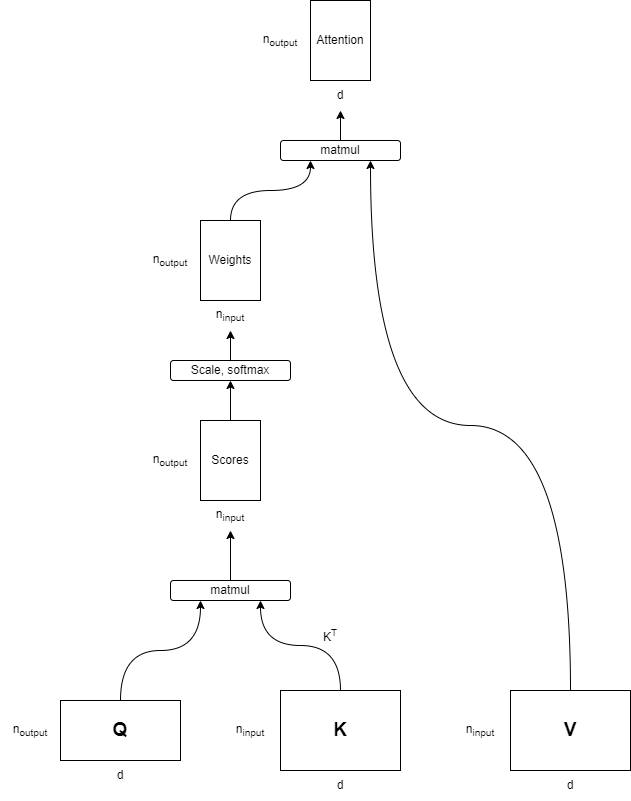

You can trace the dimensions of the different matrices at different steps in the calculation. At the end, we expect the result to have the shape `(output_sequence_length, vocabulary_size)`.

**NOTE:** You might be expecting the result to be of shape `(output_sequence_length, input_sequence_length)` because of how we understand attention intuitively. This is a correct expectation! The result of the attention function is critical to building transformers, but the result of the first matrix multiplication (the score matrix) is what is known as the *attention matrix*.

We can start by scoring a query against a key. This will get us the relation between these two words.

In [176]:
np.dot(queries[0], keys[0])

3.1707535631756056

Now we do this for every key word at once:

In [177]:
scores = np.array([np.dot(queries[0], key) for key in keys])

# It is calculating the relation score of the first word in the output sentence to every
# word in the input sentence, so we expect it to have the same dimensionality as the
# input sentence
assert scores.shape == (INPUT_SENTENCE_LENGTH,)

print(scores)

[3.17075356 2.48115636 2.48115636 3.11195578 2.46003028 2.65454707
 3.17075356 1.81791341]


Then we take the softmax of these after scaling. It is generally good practice to scale the scores by the square root of the dimensionality of the key vectors. This is because if the key vectors are large, the dot products grow large as well, pushing the softmax function into regions where it has extremely small gradients. This is a trick that was introduced in the original transformer paper.

In [178]:
weights = sp.special.softmax(scores / (VOCABULARY_SIZE**0.5))

# This operation shouldn't change the shape, only the values
assert weights.shape == scores.shape

weights

array([0.14514296, 0.116705  , 0.116705  , 0.14246918, 0.11592794,
       0.12328273, 0.14514296, 0.09462423])

We can then use these weights to create a weighted sum of the value vector. The result of this is the attention vector for our input sentence.

In [179]:
attention = sum(
    [np.dot(weights[index], values[index]) for index in range(INPUT_SENTENCE_LENGTH)]
)

# This the attention vector for only one word, so we expect it to only be the size of
# the vocabulary
assert attention.shape == (VOCABULARY_SIZE,)

attention

array([0.56776484, 0.42919222, 0.45483751, 0.37362664, 0.50926416,
       0.40020751, 0.47256763, 0.46993472, 0.55653554, 0.65328568])

## Calculating attention for a sentence

The above method works just fine, but we can optimize it using matrix operations. We start by stacking the list of word vectors into sentence matrices:

In [180]:
input_sentence = np.array(input_words)
output_sentence = np.array(output_words)

print(f"Number of input words: {len(input_words)}")
print(f"Shape of a word vector: {input_words[0].shape}")
print(f"Shape of the input sentence matrix: {input_sentence.shape}")
print()
print("Input sentence matrix:")
print(input_sentence)

Number of input words: 8
Shape of a word vector: (10,)
Shape of the input sentence matrix: (8, 10)

Input sentence matrix:
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]


We can use the same weight matrices to generate our $Q$, $K$, and $V$ matrices for the sentences:

In [181]:
query = np.matmul(output_sentence, weights_query)
key = np.matmul(input_sentence, weights_key)
value = np.matmul(input_sentence, weights_value)

# The matrices should have the same shapes as their source sentences
assert query.shape == output_sentence.shape
assert key.shape == input_sentence.shape
assert value.shape == input_sentence.shape

print(f"Shape of the output sentence matrix: {output_sentence.shape}")
print(f"Shape of the query weights matrix: {weights_query.shape}")
print(f"Shape of the query matrix: {query.shape}")

Shape of the output sentence matrix: (13, 10)
Shape of the query weights matrix: (10, 10)
Shape of the query matrix: (13, 10)


We can calculate all of our scores at once:

In [182]:
score = np.matmul(query, key.T)

# The scores are every output word for every input word, so we expect the shape to be
# a rectangle with the two sentence lengths as dimensions
assert score.shape == (OUTPUT_SENTENCE_LENGTH, INPUT_SENTENCE_LENGTH)

print(f"Shape of the query matrix: {query.shape}")
print(f"Shape of the key matrix: {key.shape}")
print(f"Shape of the score matrix: {score.shape}")

Shape of the query matrix: (13, 10)
Shape of the key matrix: (8, 10)
Shape of the score matrix: (13, 8)


And all of our weights at once:

In [183]:
weight = sp.special.softmax(score / (VOCABULARY_SIZE**0.5), axis=1)

# This operation shouldn't change the shape, only the values
assert weight.shape == score.shape

print(f"Shape of the weight matrix: {weight.shape}")

Shape of the weight matrix: (13, 8)


And lastly our attention all at once:

In [184]:
attention = np.matmul(weight, value)

# See the above note in "Calculating attention for one word" for an explanation of why
# this is the shape
assert attention.shape == (OUTPUT_SENTENCE_LENGTH, VOCABULARY_SIZE)

print(f"Shape of the attention matrix: {attention.shape}")

attention

Shape of the attention matrix: (13, 10)


array([[0.56776484, 0.42919222, 0.45483751, 0.37362664, 0.50926416,
        0.40020751, 0.47256763, 0.46993472, 0.55653554, 0.65328568],
       [0.59119164, 0.41192583, 0.44918864, 0.3674337 , 0.53332671,
        0.37570831, 0.45324228, 0.46866823, 0.55895598, 0.650062  ],
       [0.59119164, 0.41192583, 0.44918864, 0.3674337 , 0.53332671,
        0.37570831, 0.45324228, 0.46866823, 0.55895598, 0.650062  ],
       [0.58594759, 0.42341096, 0.44979032, 0.37344594, 0.52907394,
        0.38805452, 0.46133003, 0.46045688, 0.5500834 , 0.6474111 ],
       [0.57048592, 0.46361578, 0.47133947, 0.3942548 , 0.51886836,
        0.41615059, 0.46720532, 0.4508532 , 0.55223346, 0.64633045],
       [0.55568366, 0.44515894, 0.45747396, 0.37976891, 0.49510853,
        0.41690305, 0.48619281, 0.4672868 , 0.55054167, 0.65628816],
       [0.58326513, 0.43260528, 0.46212944, 0.37934952, 0.527155  ,
        0.38895479, 0.45412531, 0.46555113, 0.56467623, 0.65315166],
       [0.58453305, 0.43225917, 0.4609807

## Attention function implementation

Let's put together everything we've learned about attention into a function.

In [185]:
def attention(query, key, value):
    """
    Calculates an attention matrix for given input vectors.
    """

    # We expect all of our inputs to be 2-dimensional matrices (we are not using
    # batching in this example)
    assert query.ndim == 2
    assert key.ndim == 2
    assert value.ndim == 2

    vocabulary_size = query.shape[1]
    query_sequence_length = query.shape[0]
    key_sequence_length = key.shape[0]
    value_sequence_length = value.shape[0]

    # We expect the vocabulary sizes to be the same for all of the inputs
    assert key.shape[1] == vocabulary_size
    assert value.shape[1] == vocabulary_size

    # First we calculate the score matrix - this is the attention matrix
    score = np.matmul(query, key.T)

    # The scores are every output word for every input word, so we expect the shape to
    # be a rectangle with the two sentence lengths as dimensions
    assert score.shape == (query_sequence_length, key_sequence_length)

    # We apply scaling and softmax to the scores to get the weights
    weight = sp.special.softmax(score / (vocabulary_size**0.5), axis=1)

    # This operation shouldn't change the shape, only the values
    assert weight.shape == score.shape

    # Finally we calculate the result
    result = np.matmul(weight, value)

    # See the above note in "Calculating attention for one word" for an explanation of
    # why this is the shape
    assert result.shape == (query_sequence_length, vocabulary_size)

    return result

Let's test it out like before:

In [186]:
attention(query, key, value)

array([[0.56776484, 0.42919222, 0.45483751, 0.37362664, 0.50926416,
        0.40020751, 0.47256763, 0.46993472, 0.55653554, 0.65328568],
       [0.59119164, 0.41192583, 0.44918864, 0.3674337 , 0.53332671,
        0.37570831, 0.45324228, 0.46866823, 0.55895598, 0.650062  ],
       [0.59119164, 0.41192583, 0.44918864, 0.3674337 , 0.53332671,
        0.37570831, 0.45324228, 0.46866823, 0.55895598, 0.650062  ],
       [0.58594759, 0.42341096, 0.44979032, 0.37344594, 0.52907394,
        0.38805452, 0.46133003, 0.46045688, 0.5500834 , 0.6474111 ],
       [0.57048592, 0.46361578, 0.47133947, 0.3942548 , 0.51886836,
        0.41615059, 0.46720532, 0.4508532 , 0.55223346, 0.64633045],
       [0.55568366, 0.44515894, 0.45747396, 0.37976891, 0.49510853,
        0.41690305, 0.48619281, 0.4672868 , 0.55054167, 0.65628816],
       [0.58326513, 0.43260528, 0.46212944, 0.37934952, 0.527155  ,
        0.38895479, 0.45412531, 0.46555113, 0.56467623, 0.65315166],
       [0.58453305, 0.43225917, 0.4609807

If you check this result against the above result, you can see that they are the same!